#### Alexandre ROUXEL : MDI 343 Challenge
> This note book is linked with the pdf document :
arouxel_MDI_343_challenge.pdf
The main explainations are in the pdf document


In [1]:
# java script to avoid scroling

In [2]:
%% javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

# Useful functions 

In [93]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Running time of each algorithm (in milliseconds)
alg_times = np.zeros((14, 1))
alg_times[0] = 163
alg_times[1] = 163
alg_times[2] = 190
alg_times[3] = 190
alg_times[4] = 206
alg_times[5] = 206
alg_times[6] = 120
alg_times[7] = 120
alg_times[8] = 83
alg_times[9] = 83
alg_times[10] = 83
alg_times[11] = 83
alg_times[12] = 170
alg_times[13] = 170

# Time constraint: The total duration of the algorithms cannot exceed 600 milliseconds
alg_time_thr = 600
look_at_FAR = 0.0001

# Compute the total computational time for the fusion algorithm


def compute_total_time(M, flag_check=0):
    is_used = np.zeros((14, 1))
    for i in range(15):
        for j in range(15):
            if(M[i, j] != 0):
                if(i >= 1):
                    is_used[i - 1] = 1
                if(j >= 1):
                    is_used[j - 1] = 1

    total_dur = np.dot(is_used.T, alg_times)

    if flag_check == 1:
        indices = np.linspace(1, 14, 14)
        features_selected_indices = indices[is_used.flatten().astype(int) > 0]
        print('selected algorithms in [1...14]')
        print(features_selected_indices)

    return total_dur[0, 0]

# Evaluation metric


def compute_eval(fused_score, look_at_FAR=0.0001):

    # calculating FAR and FRR
    sort = np.argsort(fused_score[:, 1])

    #sort = np.concatenate([sort[-2:],sort[:-2]], axis=0)
    scores = fused_score[sort]
    totpos = sum(scores[:, 0])
    totneg = scores.shape[0] - totpos
    fa = (np.cumsum(scores[:, 0] - 1) + totneg) / totneg
    fr = np.cumsum(scores[:, 0]) / totpos

    i = 0
    while fa[i] > look_at_FAR:
        i += 1

    return scores[i][1], fa[i], fr[i]

# Compute the score


def compute_score(M, Xcheck, Ycheck, flag_print=0):

    # apply fusion on scores
    A = Xcheck[:, None, :] * Xcheck[:, :, None]
    fuse = np.multiply(A, M)

    B2 = np.reshape(np.sum(fuse, axis=(1, 2)), [-1, 1])
    B1 = np.reshape(Ycheck, [-1, 1])

    fuse = np.concatenate([B1, B2], axis=1)
    fuse[np.isnan(fuse)] = -float("inf")

    # compute the FRR at FAR = 0.01%
    thr, fa, fr = compute_eval(fuse)

    if flag_print == 1:
        print("Score at FAR=" + str(look_at_FAR * 100.0) + "%")
        print("threshold :", thr, "far :", fa, "frr :", fr)

    return(thr, fa, fr)

## Functions to generate fusion Matrix 

In [4]:
from sklearn.preprocessing import PolynomialFeatures
# Convert a vector of quadratic features in a fusion Matrix M


def BuildM(w2, dim=15):

    M = np.zeros((dim, dim))
    diag = np.zeros((dim, 1))
    start = 0
    cpter = dim
    stop = start + cpter
    for idx, l in enumerate(range(dim)):
        M[idx, idx:] = w2[0, start:stop]
        start = stop
        cpter = cpter - 1
        stop = start + cpter

    diagonal = np.diag(np.diag(M))
    M1 = M - diagonal
    M2 = 0.5 * (M1 + M1.T) + diagonal

    return(M2)

# Convert a reduced vector of quadratic features  in a fusion Matrix M


def BuildMFromReduced(w2_reduced, features_selected_indices, dimM=15):

    nbFeatures2D = len(features_selected_indices)
    M_reduced_dim = BuildM(w2_reduced, dim=nbFeatures2D)
    M_dimM = np.zeros((dimM, dimM))
    for idx, k in enumerate(features_selected_indices.flatten()):
        M_dimM[k, features_selected_indices] = M_reduced_dim[idx, :]
    return(M_dimM)

# Generatea polynomial features from a subset of features
# features_selected_indices does not include intercept
# i.e first element is not zero


def GenPoly(X, features_selected_indices):

    poly = PolynomialFeatures(
        degree=2, interaction_only=False, include_bias=True)

    X_reduced = X[:, features_selected_indices.astype(int)]
    X_2D = poly.fit_transform(X_reduced)
    norm = np.sqrt(sum(np.var(X_2D, axis=0)))
    X_2D[:, 1:] = X_2D[:, 1:] / norm

    return(X_2D)

## PCA specific functions

In [5]:
from numpy.linalg import eig

# Computes correlation of features corresponding
# to the 2 labels


def ComputeRnp(X, Y):

    Rpos = X[Y == 1, :]
    Rpos = np.dot(Rpos.T, Rpos)
    Gneg = X[Y == -1, :]
    Rneg = np.dot(Gneg.T, Gneg)
    R2p = np.dot(Rpos.T, Rpos)
    R2n = np.dot(Gneg.T, Gneg)

    return(R2p, R2n)

# Computes a corelation matrices of features
# with a weigh on lines corresponding to negative Y


def ComputeRnp_beta(X, Y, beta):

    X1 = X.copy()
    X1[Y == -1, :] = -beta * X1[Y == -1, :]
    G2np = np.dot(X1.T, X1)

    return(G2np)

In [48]:
from numpy.linalg import norm

# Compute principal eigen vetor of a correlation matrix


def ComputeTheta(R2, flag_plot=0):

    wp, vp = eig(R2)
    max_vp_idx = np.argmax(wp)
    # take the real part, the vp is real
    # but for numerical precision reason
    # imaginary part could be 1e-15
    vp_max = np.real(vp[:, max_vp_idx])
    s = np.sum(vp_max)

    # set the sign in order to have maximum positive
    # it is just a convention
    if s < 0:
        vp_max = -vp_max
    vp_max = vp_max / norm(vp_max, 2)
    if flag_plot == 1:
        plt.figure()
        plt.plot(vp_max)

    return(vp_max.reshape(-1, 1))

# Computes scores fa et tr and fusion matrix for feature corresponding to only positive
# or only negative labels


def ComputePNScore(X_2D_train, Y_train, X_2D_test, Y_test,
                   features_selected_indices, flag_score=0, flag_plot=0):

    features_selected_indices_1D = np.append([0], features_selected_indices)

    # computes corelation matrices
    G2p_train, G2n_train = ComputeRnp(X_2D_train, Y_train)

    # computes max eigen vectors
    vp_max = ComputeTheta(G2p_train, flag_plot=flag_plot)
    vn_max = ComputeTheta(G2n_train, flag_plot=flag_plot)

    # build the fusion marix
    # only positive label
    Mp = BuildMFromReduced(vp_max.T, features_selected_indices_1D)

    # only negative label
    Mn = BuildMFromReduced(vn_max.T, features_selected_indices_1D)

    tot_dur = compute_total_time(Mp)

    Y_test[Y_test < 0] = 0
    # compute fr,fa for features (i.e scores) associated to positive labels
    thr_tab_p, fa_tab_p, fr_tab_p = compute_score(Mp, X_test, Y_test)
    # compute fr,fa for features (i.e scores) associated to negatives labels
    thr_tab_n, fa_tab_n, fr_tab_n = compute_score(Mn, X_test, Y_test)

    if flag_score == 1:
        return(fr_tab_p, fr_tab_n, tot_dur)
    else:
        return(Mp, Mn)

# Computes scores fa et tr and fusion matrix with negative feautures weighted by
# beta


def ComputeBetaScore(X_2D_train, Y_train, X_2D_test, Y_test,
                     features_selected_indices, beta=0.8, flag_score=0, flag_plot=0):

    # features_selected_indices does not inlcude 0
    features_selected_indices_1D = np.append([0], features_selected_indices)

    # computes corelation matrices
    G2np_train = ComputeRnp_beta(X_2D_train, Y_train, beta)

    # computes max eigen vectors
    vpn_max = ComputeTheta(G2np_train, flag_plot=flag_plot)
    Mpn = BuildMFromReduced(vpn_max.T, features_selected_indices_1D)

    Y_test[Y_test < 0] = 0
    thr_tab_pn, fa_tab_pn, fr_tab_pn = compute_score(Mpn, X_test, Y_test)

    if flag_score == 1:
        return(fr_tab_pn)
    else:
        return(Mpn)

## Functions to generate data sets

In [6]:
from sklearn.utils import shuffle

# generate a reduced set of data with the same label repartition than the full set
# to accelerate the simulations


def ShuffleData(X, Y, nusp=5, nusn=5):

    Xp = X[Y == 1, :]
    Xn = X[Y == -1, :]
    Yp = Y[Y == 1]
    Yn = Y[Y == -1]
    print("nb of 1")
    print(len(Yp))
    print("nb of -1")
    print(len(Yn))

    Xpus = Xp[0::nusp, :]
    Xnus = Xn[0::nusn, :]
    Ypus = Yp[0::nusp]
    Ynus = Yn[0::nusn]

    Xus = np.append(Xpus, Xnus, axis=0)
    Yus = np.append(Ypus, Ynus, axis=0)
    Xus, Yus = shuffle(Xus, Yus, random_state=0)

    return(Xus, Yus)

## Load and clean the data

In [7]:
from sklearn.model_selection import train_test_split

# Load the data
train_fname = 'train15_telecom.txt'
# The first column contains the labels, the rest of the columns contains the scores
train_data = np.loadtxt(train_fname, dtype=np.float)

# Extract the labels
y_trn = train_data[:, 0].astype(int)

# Extract the score vectors
s_trn = train_data.copy()
# Put a 1 in front of all the scores (see the "Fusion method" section above)
s_trn[:, 0] = 1;

# clean the data
X = s_trn
y = y_trn

# drop infinite numbers
lines_inf, algo_indx = np.where(np.isinf(X) == True)
lines_not_inf, algo_indx = np.where(np.isinf(X) == False)
X1 = np.delete(X, np.unique(lines_inf), axis=0)
Y1 = np.delete(y, np.unique(lines_inf), axis=0)

# drop negative numbers
lines_neg, algo_neg = np.where(X1 < 0)
Xclean = np.delete(X1, np.unique(lines_neg), axis=0)
Yclean = np.delete(Y1, np.unique(lines_neg), axis=0)

Xclean_check_us = Xclean[0::5, :]
Yclean_check_us = Yclean[0::5]
Xclean_check = Xclean
Yclean_check = Yclean

## Generates training and test set 

In [8]:
X = Xclean_check.copy()
Y = Yclean_check.copy()
Y[Y == 0] = -1

# training  and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None, stratify=None)

print("Ratio of positive labels")
print(len(Y_train[Y_train == 1]) / len(Y_train[Y_train == -1]))

Ratio of positive labels
0.025513390650013203


# Join Features selection and Fusion Matrix optimisation
> In this part I use a linear SVM classifier with L1 constraint to select features and optimize the fusion jointly 
    <p> In the second part I re-optimized the linear SVM classfier with L2 constraint

## Feature selection based on SVM with L1 constraint

In [ ]:
import time
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp


# training  and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=None)

# First path all the algorithms are selected
# In the second path only the selected algorithm are used
# features_selected_indices = [7,9,11,13]
features_selected_indices = np.linspace(1, 14, 14).astype(int)
X_2D_train = GenPoly(X_train, features_selected_indices)

# range of alpha
# alpha = exp(-alpha_exp_range)
alpha_exp_range = np.linspace(9, 12, 31)
nb_alpha = len(alpha_exp_range)
# array of theta
n_features_2D = X_2D_train.shape[1]
coefs_opti = np.zeros((len(alpha_exp_range), n_features_2D))
coefs = np.zeros((len(alpha_exp_range), n_features_2D))

# Scores
# ROC curves
Max_FT = 1e-3  # maximum FAR used to plot ROC Curves
mean_fpr = np.linspace(0, Max_FT, 1000)
# True Positive = 1-FRR
tprs = np.zeros((len(alpha_exp_range), len(mean_fpr)))
# Area Under Roc

aurocs = np.zeros(nb_alpha)
aurocs_mean = np.zeros(nb_alpha)
aurocs_var = np.zeros(nb_alpha)
aurocs_max = np.zeros(nb_alpha)
aurocs_min = np.zeros(nb_alpha)
fuse_time_mean = np.zeros(nb_alpha)
fuse_time_var = np.zeros(nb_alpha)

fuse_time_max = np.zeros(nb_alpha)
fuse_time_min = np.zeros(nb_alpha)

# to check the speed
time_tab = np.zeros(nb_alpha)

# apriori information on label distribution
class_weight = {1: 0.025, 0: 0.975}

# set the negative label to 0
Y_train[Y_train == -1] = 0
Y_test[Y_test == -1] = 0
Y[Y == -1] = 0

# Coef applied to filter out small Theta
# coef which is less eps_filter of the max is set to 0
eps_filter = 1e-3

# Random split
n_splits = 3
rs = ShuffleSplit(n_splits=n_splits, train_size=0.5,
                  test_size=.25, random_state=42)

for alpha_idx, alpa_exp in enumerate(alpha_exp_range):

    alpa_exp = alpha_exp_range[alpha_idx]
    t = time.time()

    auroc_test = np.zeros(n_splits)
    fuse_time = np.zeros(n_splits)
    split_idx = -1

    print("alpha")
    print(alpa_exp)

    for train_index, test_index in rs.split(X_2D_train):

        split_idx = split_idx + 1

        X_2D_train_split = X_2D_train[train_index]
        X_2D_test_split = X_2D_train[test_index]
        Y_train_split = Y_train[train_index]
        Y_test_split = Y_train[test_index]

        clf = SGDClassifier(loss='hinge', penalty='l1', alpha=np.exp(-alpa_exp),
                            l1_ratio=1, fit_intercept=False,
                            max_iter=1000, tol=1e-5, shuffle=True, verbose=0,
                            epsilon=0.1, n_jobs=-1, random_state=None,
                            learning_rate='optimal', eta0=0.0,
                            power_t=0.5, class_weight=class_weight, warm_start=False, average=False, n_iter=None)

        clf.fit(X_2D_train_split, Y_train_split)

        y_test_score = clf.decision_function(X_2D_test_split)

        # compute the ROC curves
        fpr, tpr, thresholds = roc_curve(Y_test_split, y_test_score, pos_label=None,
                                         sample_weight=None, drop_intermediate=True)

        # Area under ROC curves
        auroc_test[split_idx] = auc(fpr, tpr)

        # Filter out small coef
        coefs_opti = clf.coef_
        coefs_filtered = clf.coef_.copy()
        max_coef = np.max(abs(coefs_filtered))
        coefs_filtered[np.abs(coefs_filtered) < eps_filter * max_coef] = 0

        # Compute processing time
        #M = BuildMFromReduced(coefs_filtered)
        M = BuildM(coefs_filtered)
        algo_time = compute_total_time(M)
        fuse_time[split_idx] = algo_time

    aurocs_mean[alpha_idx] = np.mean(auroc_test)
    aurocs_var[alpha_idx] = np.var(auroc_test)
    aurocs_max[alpha_idx] = np.max(auroc_test)
    aurocs_min[alpha_idx] = np.min(auroc_test)

    fuse_time_mean[alpha_idx] = np.mean(fuse_time)
    fuse_time_var[alpha_idx] = np.var(fuse_time)
    fuse_time_min[alpha_idx] = np.min(fuse_time)
    fuse_time_max[alpha_idx] = np.max(fuse_time)

    print("mean processing time ")
    print(fuse_time_mean[alpha_idx])
    print("mean auroc")
    print(np.mean(auroc_test))

    elapsed = time.time() - t
    time_tab[alpha_idx] = elapsed
    print("====== time ==== ")
    print(elapsed)

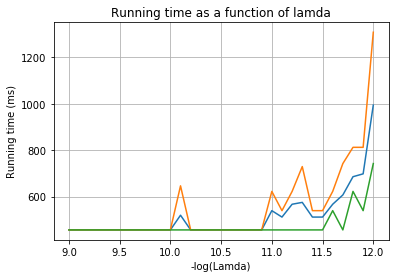

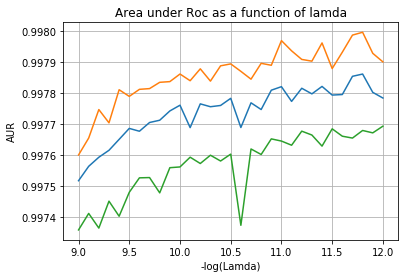

In [57]:
plt.figure
plt.plot(alpha_exp_range, fuse_time_mean, label='mean')
plt.plot(alpha_exp_range, fuse_time_max, label='max')
plt.plot(alpha_exp_range, fuse_time_min, label='min')
plt.title("Running time as a function of lamda")
plt.xlabel('-log(Lamda)')
plt.ylabel('Running time (ms)')
plt.grid()
plt.show()

plt.figure
plt.plot(alpha_exp_range, aurocs_mean, label='mean')
plt.plot(alpha_exp_range, aurocs_max, label='max')
plt.plot(alpha_exp_range, aurocs_min, label='min')
plt.title("Area under Roc as a function of lamda")
plt.xlabel('-log(Lamda)')
plt.ylabel('AUR')
plt.grid()
plt.show()

## Optimisation based on SVM with L2 constraint

In [ ]:
import time
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp


# training  and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=19, stratify=None)

# First path all the algorithms are selected
# In the second path only the selected algorithm are used
features_selected_indices = np.array([7, 9, 11, 13])
features_selected_indices_1D = np.append([0], features_selected_indices)


# features_selected_indices = np.linspace(1, 14, 14).astype(int)
X_2D_train = GenPoly(X_train, features_selected_indices)

# range of alpha
# alpha = exp(-alpha_exp_range)
alpha_exp_range = np.linspace(9.0, 10, 11)
nb_alpha = len(alpha_exp_range)
# array of theta
n_features_2D = X_2D_train.shape[1]
coefs_opti = np.zeros((len(alpha_exp_range), n_features_2D))
coefs = np.zeros((len(alpha_exp_range), n_features_2D))

# Scores
# ROC curves
Max_FT = 1e-3  # maximum FAR used to plot ROC Curves
mean_fpr = np.linspace(0, Max_FT, 1000)
# True Positive = 1-FRR
tprs = np.zeros((len(alpha_exp_range), len(mean_fpr)))
# Area Under Roc

fr = np.zeros(nb_alpha)
fr_mean = np.zeros(nb_alpha)
fr_var = np.zeros(nb_alpha)
fr_max = np.zeros(nb_alpha)
fr_min = np.zeros(nb_alpha)
fuse_time_mean = np.zeros(nb_alpha)
fuse_time_var = np.zeros(nb_alpha)

fuse_time_max = np.zeros(nb_alpha)
fuse_time_min = np.zeros(nb_alpha)

# to check the speed
time_tab = np.zeros(nb_alpha)

# apriori information on label distribution
class_weight = {1: 0.025, 0: 0.975}

# set the negative label to 0
Y_train[Y_train == -1] = 0
Y_test[Y_test == -1] = 0
Y[Y == -1] = 0

# Coef applied to filter out small Theta
# coef which is less eps_filter of the max is set to 0
eps_filter = 1e-3

# Random split
n_splits = 3
rs = ShuffleSplit(n_splits=n_splits, train_size=0.5,
                  test_size=.25, random_state=42)

for alpha_idx, alpa_exp in enumerate(alpha_exp_range):

    alpa_exp = alpha_exp_range[alpha_idx]
    t = time.time()

    fr_test = np.zeros(n_splits)
    fuse_time = np.zeros(n_splits)
    split_idx = -1

    print("alpha")
    print(alpa_exp)

    for train_index, test_index in rs.split(X_2D_train):

        split_idx = split_idx + 1

        X_2D_train_split = X_2D_train[train_index]
        X_2D_test_split = X_2D_train[test_index]
        Y_train_split = Y_train[train_index]
        Y_test_split = Y_train[test_index]

        clf = SGDClassifier(loss='hinge', penalty='l2', alpha=np.exp(-alpa_exp),
                            l1_ratio=1, fit_intercept=False,
                            max_iter=1000, tol=1e-5, shuffle=True, verbose=0,
                            epsilon=0.1, n_jobs=-1, random_state=None,
                            learning_rate='optimal', eta0=0.0,
                            power_t=0.5, class_weight=class_weight, warm_start=False, average=False, n_iter=None)

        clf.fit(X_2D_train_split, Y_train_split)

        y_test_score = clf.decision_function(X_2D_test_split)

        # compute the ROC curves
        fpr, tpr, thresholds = roc_curve(Y_test_split, y_test_score, pos_label=None,
                                         sample_weight=None, drop_intermediate=True)

        # Area under ROC curves
        #auroc_test[split_idx] = auc(fpr, tpr )

        # Filter out small coef
        coefs_opti = clf.coef_
        coefs_filtered = clf.coef_.copy()
        max_coef = np.max(abs(coefs_filtered))
        coefs_filtered[np.abs(coefs_filtered) < eps_filter * max_coef] = 0

        # Compute processing time
        M = BuildMFromReduced(coefs_filtered, features_selected_indices_1D)
        #M = BuildM(coefs_filtered)
        algo_time = compute_total_time(M)
        fuse_time[split_idx] = algo_time
        thr, fa, fr = compute_score(M, X_test, Y_test, flag_print=0)
        print(fr)
        auroc_test[split_idx] = fr

    fr_mean[alpha_idx] = np.mean(auroc_test)
    fr_var[alpha_idx] = np.var(auroc_test)
    fr_max[alpha_idx] = np.max(auroc_test)
    fr_min[alpha_idx] = np.min(auroc_test)

    fuse_time_mean[alpha_idx] = np.mean(fuse_time)
    fuse_time_var[alpha_idx] = np.var(fuse_time)
    fuse_time_min[alpha_idx] = np.min(fuse_time)
    fuse_time_max[alpha_idx] = np.max(fuse_time)

    print("mean processing time ")
    print(fuse_time_mean[alpha_idx])
    print("mean auroc")
    print(np.mean(auroc_test))

    elapsed = time.time() - t
    time_tab[alpha_idx] = elapsed
    print("====== time ==== ")
    print(elapsed)

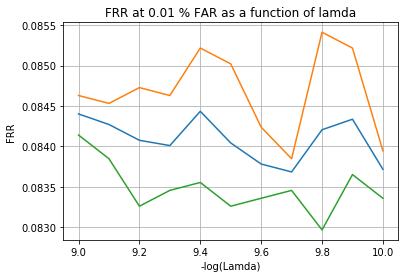

In [121]:
plt.figure
plt.plot(alpha_exp_range, fr_mean, label='mean')
plt.plot(alpha_exp_range, fr_max, label='max')
plt.plot(alpha_exp_range, fr_min, label='min')
plt.title("FRR at 0.01 % FAR as a function of lamda")
plt.xlabel('-log(Lamda)')
plt.ylabel('FRR ')

plt.grid()
plt.show()

# Computation with PCA method 
> I first generate a dictionary of all the set of algorithms filling the timing constraint. 
<p> Then I applied the method describe in the document based on PCA to optimize the fusion matrix per algorithm set

## Generate the dictionary of algorithms set filling the timing constraint

In [9]:
import itertools

idx = 0
algo_idx = range(1, 15)
dico_set = {}
for L in range(1, len(algo_idx) + 1):
    for subset in itertools.combinations(algo_idx, L):
        if sum(alg_times[np.asarray(subset) - 1, 0]) < alg_time_thr:
            idx = idx + 1
            dico_set[idx] = subset

## Compute the scores of the set of algorithms filling the timing constraint

In [ ]:
import time
from sklearn.linear_model import SGDClassifier

# beta factor tuning
beta_range = np.linspace(1, 1, 1)

# init tabs
fr_tab_p = np.zeros((len(dico_set) + 1, 1))
fr_tab_n = np.zeros((len(dico_set) + 1, 1))
fr_tab_pn = np.zeros((len(dico_set) + 1, len(beta_range)))
time_tab = np.zeros((len(dico_set) + 1, 1))

idx = 0
for key in dico_set:

    t = time.time()

    idx = idx + 1
    features_selected_indices = np.asarray(dico_set[key])
    print('index of selected features ')
    print(features_selected_indices)

    # features_selected_indices does not inlcude intercept
    X_2D_test = GenPoly(X_test, features_selected_indices)
    X_2D_train = GenPoly(X_train, features_selected_indices)

    # compute the score for positive and negative labels
    fr_p, fr_n, tot_dur = ComputePNScore(X_2D_train, Y_train, X_2D_test, Y_test,
                                         features_selected_indices,
                                         flag_score=1,
                                         flag_plot=0)

    fr_tab_p[idx] = fr_p
    fr_tab_n[idx] = fr_n

    for idx_aplha, alpha in enumerate(beta_range):
        fr_pn = ComputeBetaScore(X_2D_train, Y_train, X_2D_test, Y_test,
                                 features_selected_indices, alpha, flag_score=1,
                                 flag_plot=0)

        fr_tab_pn[idx, idx_aplha] = fr_pn

    print("FR score for positive and negative labels ")
    print(fr_p, fr_n)

    elapsed = time.time() - t
    print("====== elapsed time ==== ")
    print(elapsed)
    time_tab[idx] = elapsed

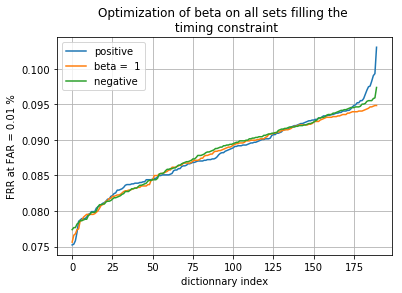

In [11]:
pn1 = fr_tab_pn[:, 0]
a = pn1.flatten()
indx = np.logical_and(a > 0, a < 0.095)
plt.figure
plt.plot(np.sort(fr_tab_p[indx].flatten()), label='positive')
plt.plot(np.sort(pn1[indx].flatten()), label='beta =  1')
plt.plot(np.sort(fr_tab_n[indx].flatten()), label='negative ')
plt.xlabel('dictionnary index')
plt.ylabel('FRR at FAR = 0.01 %')
plt.title('Optimization of beta on all sets filling the \n timing constraint')
plt.legend()
plt.grid()
plt.show()

In [31]:
# sort the scores and find the best one
idx_test = 0
print("Positive features selection")
print("--------------------------")
fr_tab_p[0] = 0.5
idx_max_score_p = np.argsort(fr_tab_p.flatten())
best_score_p = np.sort(fr_tab_p.flatten())
print("Algorithms indices")
print(dico_set[idx_max_score_p[idx_test]])
print("Dictionary index")
print(idx_max_score_p[idx_test])
print("Best score ")
print(fr_tab_p[idx_max_score_p[idx_test]])

print("Negative features selection")
print("--------------------------")
fr_tab_p[0] = 0.5
idx_max_score_n = np.argsort(fr_tab_n.flatten())
best_score_n = np.sort(fr_tab_n.flatten())
print("Algorithms indices")
print(dico_set[idx_max_score_n[idx_test]])
print("Dictionary index")
print(idx_max_score_n[idx_test])
print("Best score ")
print(fr_tab_n[idx_max_score_n[idx_test]])

print("Weighting of features by beta")
print("-----------------------------")
fr_tab_p[0] = 0.5
idx_max_score_pn = np.argsort(fr_tab_pn.flatten())
best_score_pn = np.sort(fr_tab_n.flatten())
print("Dictionary index")
print(idx_max_score_n[idx_test])
print("Algorithms indices")
print(dico_set[idx_max_score_pn[idx_test]])
print("Best score ")
print(fr_tab_pn[idx_max_score_pn[idx_test]])

Positive features selection
--------------------------
Algorithms indices
(7, 9, 10, 11, 13)
Dictionary index
1176
Best score 
[ 0.07522685]
Negative features selection
--------------------------
Algorithms indices
(7, 9, 10, 11, 13)
Dictionary index
1176
Best score 
[ 0.0773734]
Weighting of features by beta
-----------------------------
Dictionary index
1176
Algorithms indices
(7, 9, 10, 11, 13)
Best score 
[ 0.07561713]


>> The optimal set  given above is provided by the optimization based on PCA, it is used to feed the following cell 

## Compute the Fusion matrices to submit
> Generate the fusion matrix for any set of algorithms

In [51]:
import time
from sklearn.linear_model import SGDClassifier

# beta factor tuning
beta_range = np.linspace(1, 1, 1)

# init tabs
fr_tab_p = np.zeros((len(dico_set) + 1, 1))
fr_tab_n = np.zeros((len(dico_set) + 1, 1))
fr_tab_pn = np.zeros((len(dico_set) + 1, len(beta_range)))
time_tab = np.zeros((len(dico_set) + 1, 1))

idx = 0

for key in [1176]:

    t = time.time()

    idx = idx + 1
    features_selected_indices = np.asarray(dico_set[key])
    print('index of selected features ')
    print(features_selected_indices)

    # features_selected_indices does not inlcude intercept
    X_2D_test = GenPoly(X_test, features_selected_indices)
    X_2D_train = GenPoly(X_train, features_selected_indices)

    # compute the score for positive and negative labels
    M_p, M_n = ComputePNScore(X_2D_train, Y_train, X_2D_test, Y_test,
                              features_selected_indices,
                              flag_score=0,
                              flag_plot=0)

    for idx_aplha, alpha in enumerate(beta_range):
        M_pn = ComputeBetaScore(X_2D_train, Y_train, X_2D_test, Y_test,
                                features_selected_indices, beta=1, flag_score=0,
                                flag_plot=0)

    elapsed = time.time() - t
    print("====== elapsed time ==== ")
    print(elapsed)
    time_tab[idx] = elapsed

index of selected features 
[ 7  9 10 11 13]
====== elapsed time ==== 
5.855417013168335


In [114]:
M_submit = M
# Submission
# Write the matrix M to the disk:
np.savetxt('M_pred.txt', M_submit, fmt='%f')

Now, you can submit score_pred.txt to the challenge website.

Bonne chance !